## Introduction

This example will show the steps needed to build a 3D convolutional neural network (CNN)
to predict the presence of viral pneumonia in computer tomography (CT) scans.

2D CNNs are commonly used to process RGB images (3 channels). A 3D CNN is simply the 3D equivalent:
it takes as input a 3D volume or a sequence of 2D frames (e.g. slices in a CT scan),
3D CNNs are a powerful model for learning representations for volumetric data.

## References

- [A survey on Deep Learning Advances on Different 3D DataRepresentations](https://arxiv.org/pdf/1808.01462.pdf)
- [VoxNet: A 3D Convolutional Neural Network for Real-Time ObjectRecognition](https://www.ri.cmu.edu/pub_files/2015/9/voxnet_maturana_scherer_iros15.pdf)
- [FusionNet: 3D Object Classification Using MultipleData Representations](http://3ddl.cs.princeton.edu/2016/papers/Hegde_Zadeh.pdf)
- [Uniformizing Techniques to Process CT scans with 3D CNNs for Tuberculosis Prediction](https://arxiv.org/abs/2007.13224)

In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

## Downloading the MosMedData:Chest CT Scans with COVID-19 Related Findings

In this example, we use a subset of the
[MosMedData: Chest CT Scans with COVID-19 Related Findings](https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1). This dataset consists of lung CT scans with COVID-19 related findings, as well as without such findings.

We will be using the associated radiological findings of the CT scans as labels to build a classifier to predict presence of viral pneumonia.
Hence, the task is a binary classification problem.

In [2]:
# download url of normal CT scans
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
filename = os.path.join(os.getcwd(), "CT-0.zip")
keras.utils.get_file(filename, url)

# download url of abnormal CT scans
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-1.zip"
filename = os.path.join(os.getcwd(), "CT-1.zip")
keras.utils.get_file(filename, url)

# make a directory to store the data
os.makedirs("MosMedData")

# unzip data in the newly created directory
with zipfile.ZipFile("CT-0.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

with zipfile.ZipFile("CT-1.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

1050902528/1050898487 [==============================] - 22s 0us/step


## Load data

The files are provided in Nifti format with the extension .nii. To read the
scans, we use the `nibabel` package.
You can install the package via `pip install nibabel`.

To process the data, we do the following:

* We first rotate the volumes by 90 degrees, so the orientation is fixed
* We resize width, height and depth.

Here we define several helper functions to process the data. These functions
will be used when building training and validation datasets.

In [3]:
import numpy as np
import nibabel as nib
import cv2

from scipy.ndimage import zoom


def read_nifti_file(filepath):
    """Read and load volume"""
    # read file
    scan = nib.load(filepath)
    # get raw data
    scan = scan.get_fdata()
    # rotate
    scan = np.rot90(np.array(scan))
    return scan


def resize_slices(img):
    """Resize width and height"""
    # resize all slices
    flatten = [
        cv2.resize(img[:, :, i], (128, 128), interpolation=cv2.INTER_CUBIC)
        for i in range(img.shape[-1])
    ]
    # stack along the z-axis
    img = np.array(np.dstack(flatten))
    return img


def resize_depth(img):
    """Resize across z-axis"""
    # set the desired depth
    desired_depth = 64
    # get current depth
    current_depth = img.shape[-1]
    # compute depth factor
    depth = current_depth / desired_depth
    depth_factor = 1 / depth
    # resize across z-axis
    img_new = zoom(img, (1, 1, depth_factor), mode="nearest")
    return img_new


def process_scan(path):
    """Read and resize volume"""
    # read scan
    volume = read_nifti_file(path)
    # resize width and height
    volume = resize_slices(volume)
    # resize across z-axis
    volume = resize_depth(volume)
    return volume

Let's read the paths of the CT scans from the class directories.

In [4]:
# folder "CT-0" consist of CT scans having normal lung tissue, 
# no CT-signs of viral pneumonia
normal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-0", x)
    for x in os.listdir("MosMedData/CT-0")
]
# folder "CT-1" consist of CT scans having several ground-glass opacifications, 
# involvement of lung parenchyma
abnormal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-1", x)
    for x in os.listdir("MosMedData/CT-1")
]

print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))

CT scans with normal lung tissue: 100
CT scans with abnormal lung tissue: 100


Let's visualize a CT scan and it's shape.

Dimension of the CT scan is: (512, 512, 40)


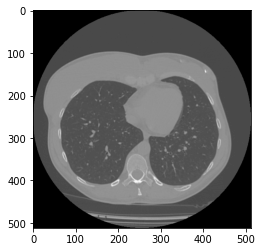

In [5]:
import matplotlib.pyplot as plt

# read a scan
img = read_nifti_file(normal_scan_paths[15])
print("Dimension of the CT scan is:", img.shape)
plt.imshow(img[:, :, 15], cmap="gray")

Since a CT scan has many slices, let's visualize a montage of the slices.

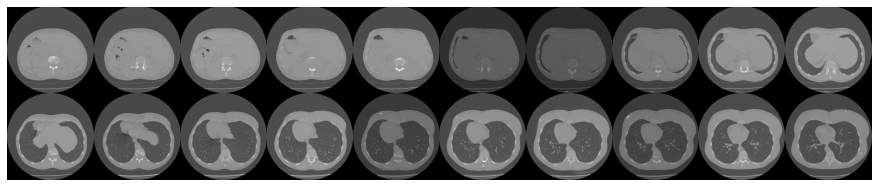

In [6]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# display 20 slices from the CT scan
# here we visualize 20 slices, 2 rows and 10 columns
# adapt it according to your need
plot_slices(2, 10, 512, 512, img[:, :, :20])

## Build train and validation datasets
Read the scans from the class directories and assign labels. Downsample the scans to have shape of 128x128x64.
Lastly, split the dataset into train and validation subsets.

In [7]:
# read and process the scans
# each scan is resized across width, height, and depth
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

# for the CT scans having presence of viral pneumonia
# assign 1, for the normal ones assign 0.
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

# split data in the ratio 70-30 for training and validation
x_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)
y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)
x_val = np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)
y_val = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 140 and 60.


## Preprocessing and data augmentation

CT scans store raw voxel intensity in Hounsfield units (HU). They range from
-1024 to above 2000 in this dataset. Above 400 are bones with different
radiointensity, so this is used as a higher bound. A threshold between
-1000 and 400 is commonly used to normalize CT scans. The CT scans are
also augmented by rotating and blurring. There are different kinds of
preprocessing and augmentation techniques out there, this example shows a few
simple ones to get started.

In [8]:
import random

from scipy import ndimage
from scipy.ndimage import gaussian_filter


@tf.function
def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume = volume - min / max - min
    volume_min = tf.reduce_min(volume)
    volume_max = tf.reduce_max(volume)
    normalized_volume = (volume - volume_min) / (volume_max - volume_min)
    normalized_volume = tf.expand_dims(normalized_volume, axis=3)
    return normalized_volume


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float64)
    return augmented_volume


@tf.function
def blur(volume):
    """Blur the volume"""

    def scipy_blur(volume):
        # gaussian blur
        volume = gaussian_filter(volume, sigma=1)
        return volume

    augmented_volume = tf.numpy_function(scipy_blur, [volume], tf.float64)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating, blur and normalizing."""
    # rotate data
    volume = rotate(volume)
    # blur data
    volume = blur(volume)
    # normalize
    volume = normalize(volume)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only normalizing."""
    volume = normalize(volume)
    return volume, label

While defining the train and validation data loader, the training data is passed through and
augmentation function which randomly rotates or blurs the volume and finally normalizes it
to have values between 0 and 1. 

For the validation data, the volumes are only normalized.

In [9]:
# define data loaders
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# augment the on the fly during training
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# only rescale
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

Visualize an augmented CT scan.

Dimension of the CT scan is: (128, 128, 64, 1)


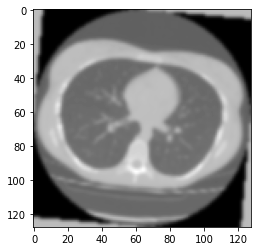

In [10]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

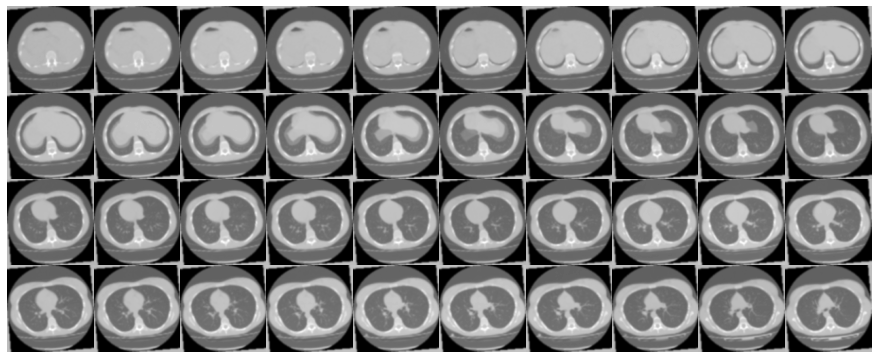

In [11]:
# visualize montage of slices
# 10 rows and 10 columns for 100 slices of the CT scan
plot_slices(4, 10, 128, 128, image[:, :, :40])

## Define a 3D convolutional neural network

To make the model easier to understand, we structure it into blocks.
The architecture of the 3D CNN used in this example
is based on [this paper](https://arxiv.org/abs/2007.13224).

In [12]:
def get_model(width=128, height=128, depth=64):
    """build a 3D convolutional neural network model"""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # define the model
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# build model
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 126, 126, 62, 64)  1792      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 63, 63, 31, 64)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 31, 64)    256       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 61, 61, 29, 64)    110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 30, 30, 14, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 14, 64)    256   

## Train model

In [13]:
# compile model
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# define callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=10)

# train the model, doing validation at the end of each epoch.
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
70/70 - 31s - loss: 0.6924 - acc: 0.5214 - val_loss: 0.8070 - val_acc: 0.5000
Epoch 2/100
70/70 - 31s - loss: 0.7233 - acc: 0.5000 - val_loss: 0.8139 - val_acc: 0.5000
Epoch 3/100
70/70 - 31s - loss: 0.7425 - acc: 0.5357 - val_loss: 0.6863 - val_acc: 0.6333
Epoch 4/100
70/70 - 31s - loss: 0.7296 - acc: 0.5571 - val_loss: 0.7229 - val_acc: 0.5000
Epoch 5/100
70/70 - 30s - loss: 0.6920 - acc: 0.5214 - val_loss: 0.7221 - val_acc: 0.5167
Epoch 6/100
70/70 - 31s - loss: 0.7075 - acc: 0.5500 - val_loss: 0.8768 - val_acc: 0.5000
Epoch 7/100
70/70 - 30s - loss: 0.7247 - acc: 0.5000 - val_loss: 0.7409 - val_acc: 0.5000
Epoch 8/100
70/70 - 30s - loss: 0.6754 - acc: 0.6071 - val_loss: 0.6976 - val_acc: 0.5500
Epoch 9/100
70/70 - 30s - loss: 0.7063 - acc: 0.5643 - val_loss: 0.6525 - val_acc: 0.6333
Epoch 10/100
70/70 - 31s - loss: 0.6805 - acc: 0.5571 - val_loss: 0.6716 - val_acc: 0.5667
Epoch 11/100
70/70 - 30s - loss: 0.6853 - acc: 0.5786 - val_loss: 0.7196 - val_acc: 0.5833
Epoch 12

It is important to note that the number of samples is very small (only 200) and we don't specify a random seed.
As such, you can expect significant variance in the results. The full dataset
which consists of over 1000 CT scans can be found
[here](https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1). Using the full dataset, an accuracy of 83% was achieved. A variability of 6-7% in the classification performance is observed in both cases.

## Visualizing model performance

Here the model accuracy and loss for the training and the validation sets are plotted.
Since the validation set is class-balanced, accuracy provides an unbiased representation of the
model's performance.

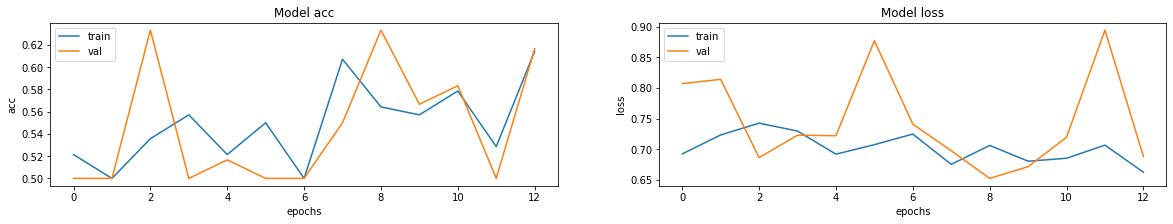

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

## Make predictions on a single CT scan

In [15]:
# load best weights
model.load_weights("3d_image_classification.h5")
prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )

This model is 0.00 percent confident that CT scan is normal
This model is 100.00 percent confident that CT scan is abnormal
